<a href="https://colab.research.google.com/github/MnCSSJ4x/Clustering-Project/blob/main/K_Means_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Summer Project : Clustering</h1>
<h3>Guide : Prof. Amit Chattopadhyay</h3>
<h5>Submitted By : Monjoy Narayan Choudhury and Karanjit Saha</h5>

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

<h1> Self Implementation of K-Means </h1> 

<h3> The part below has to be optimised </h3> 

In [26]:
def eucledian_distance(x1,x2) :
  #need to change this with LNorm 
  return np.sqrt(np.sum((x1-x2)**2)) #vector based

def minkowski_distance(x1,x2,p):
  from scipy.spatial import distance
  return distance.minkowski(x1,x2,p)

In [27]:
class Kmeans:
  #K = number of clusters
  #iter = number of iterations
  def __init__(self,K,iter,p):
    self.K=K
    self.iter=iter
    self.p=p
    #Initialising empty K clusters -> storing indicies
    self.clusters = [[] for _ in range(self.K)] 
    #storing centroids 
    self.centroids=[]

  def plus_plus(self,ds:np.array, k, random_state=1000):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

  '''def random(self,ds, k, random_state=42):
    """
    Create random cluster centroids.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    np.random.seed(random_state)
    centroids = []
    m = np.shape(ds)[0]

    for _ in range(k):
        r = np.random.randint(0, m-1)
        centroids.append(ds[r])

    return np.array(centroids)'''

  def naive_sharding(self,ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    def _get_mean(sums, step):
        """Vectorizable ufunc for getting means of summed shard columns."""
        return sums/step

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.zeros((k, n))

    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    step = math.floor(m/k)
    vfunc = np.vectorize(_get_mean)

    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids
  
  def predict(self,X,choice=0): #no fit required for unsupervised learning models
    self.X=X
    self.n_samples,self.n_features = X.shape #numpy N-d array
    
    #initialise centroids
    if choice ==0:
      random_sample_idx = np.random.choice(self.n_samples,self.K,replace=False)
      self.centroids = [self.X[idx] for idx in random_sample_idx]
    elif choice == 1:
      self.centroids=self.plus_plus(X,self.K)
    elif choice == 2:
      self.centroids=self.naive_sharding(X,self.K)
    

    #optimise 
    for _ in range(self.iter):
      #update clusters
      self.clusters=self._create_clusters(self.centroids)

      #update centroids 
      centroids_old = self.centroids #for convergence test 
      self.centroids = self._get_centroids(self.clusters)
       #get cetnroids assign mean value of cluster to the centroid
      #check for convergence
      if self._isConverged(centroids_old,self.centroids):
        break

      #break 
    #classify the samples based on index of cluster
    return self.getClusterLabels(self.clusters)
    #return cluster labels 
  def _create_clusters(self,centroids):
    clusters = [[] for _ in range(self.K)]
    for idx,sample in enumerate(self.X):
      #find the closest centroid to classify, then put it in the specific cluster
      #here cluster is an list of list 
      centroid_idx = self._closest_centroid(sample,centroids)
      clusters[centroid_idx].append(idx)
    return clusters
  def function (self,point):
    return minkowski_distance(self.sample, point, self.p)

  def _closest_centroid(self,sample,centroids):
    #distance metric  
    distances = [minkowski_distance(sample,point,self.p) for point in centroids]
    #argmin for required parameters
    closest_idx = np.argmin(distances)
    # self.sample=sample
    # closest_idx = scipy.optimize.minimize (fun=function ,x0=np.asarray(centroids))
    return closest_idx
  def _get_centroids(self,clusters):
    centroids = np.zeros((self.K,self.n_features)) #Dimension = N as N = number of features
    for cluster_idx, cluster in enumerate(clusters):
      #calling mean on a specific current cluster as X is array of various clusters
      cluster_mean = np.mean(self.X[cluster],axis = 0)
      centroids[cluster_idx] = cluster_mean #set mean as newer centroids
    return centroids 
  def _isConverged(self,centroids_old,centroids):
    distances = [minkowski_distance(centroids_old[i],centroids[i],self.p) for i in range(self.K)]
    return sum(distances)==0 #no more change occured in 2 iteration so converges 

  def getClusterLabels(self,clusters):
    labels = np.empty(self.n_samples)
    for cluster_idx,cluster in enumerate(clusters):
      for sample_idx in cluster:
        labels[sample_idx] = cluster_idx
    return labels 
  def plot(self):
    #using matplot lib
    fig,ax = plt.subplots(figsize=(16,10))
    for i, index in enumerate(self.clusters):
      point = self.X[index].T
      ax.scatter(*point)
    for point in self.centroids:
      #market is for centroid 
      ax.scatter(*point,marker = "x", color = "black" , linewidth = 2) #* is used to unfold a point
    plt.show()


    


<h1>How to prepare dataset from given files </h1>
<ul>
<li>Open the sx-ground-truth.xlsx file
<li>Copy the datasection to a newer csv
<li>Use that as input and proceed like normal 
</ul> 


In [28]:
def read_dataset_csv():
  df = pd.read_csv("/content/dataset1.csv")
  df.head()
  return df
def read_txt(filename):
  with open(filename, "r") as txt_file:
    input_data = [[int(x) for x in line.split()] for line in txt_file]
  #print(input_data)
  df=pd.DataFrame(data=input_data)
  df.head()
  return df

In [29]:
def SSE(clusters,centroids,dataframe,p=2):
  # list x list -> number
  res = 0 
  for idx,c in enumerate(clusters):
    for pt in c:
      res+=minkowski_distance(dataframe[pt],centroids[idx],p=2)
  
  return res 

def evaluate_performance(clusters,centroids,dataframe):
  print("SSE ka result = "+str(SSE(clusters, centroids ,dataframe)))


In [30]:
import matplotlib.cm as cm
def sil_visualization(X,cluster_labels,n_clusters,silhouette_avg,centroid):
  #Create a subplot with 1 row and 2 columns
  fig, (ax1) = plt.subplots(1, 1)
  fig.set_size_inches(18, 16)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  sample_silhouette_values = silhouette_samples(X, cluster_labels)
  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples  

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  #   # 2nd Plot showing the actual clusters formed
  # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  # # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

  #   # Labeling the clusters
  # centers = centroid
  #   # Draw white circles at cluster centers
  # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

  # for i, c in enumerate(centers):
  #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

  # ax2.set_title("The visualization of the clustered data.")
  # ax2.set_xlabel("Feature space for the 1st feature")
  # ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data ""with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')

  plt.show()

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
# silhouette_avg = silhouette_score(df, k.clusters)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)
    
def SIL_score(df,clusters):
  labels=generateLabels(df,clusters)
  return labels,silhouette_score(df,labels)

def generateLabels(df,clusters):
  n_samples=len(df)
  labels=np.zeros(shape=n_samples)
  for idx,val in enumerate(clusters):
    for item in val:
      labels[item]=idx 
  return labels 



For n_clusters = 20 The value of p =  1.0  The average silhouette_score is : 0.5274787440131259


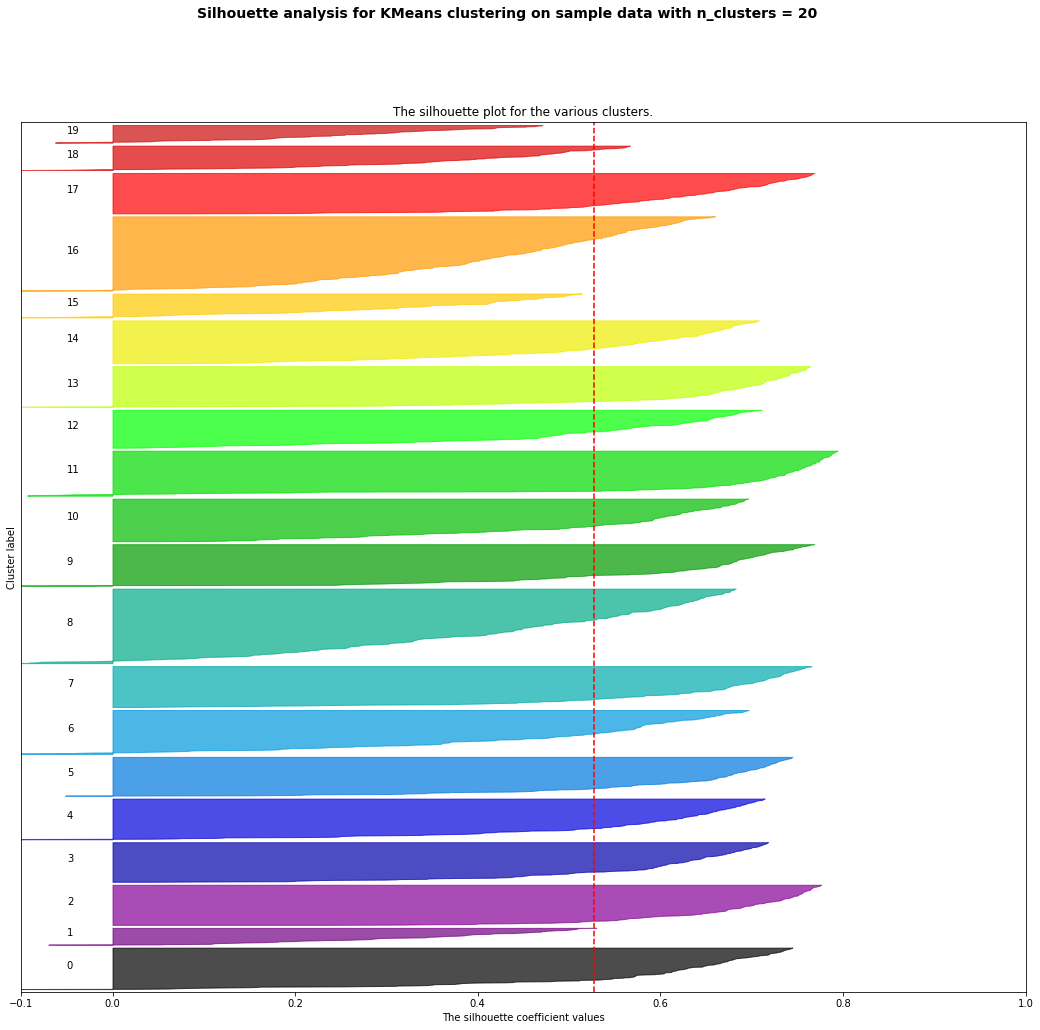

For n_clusters = 20 The value of p =  1.5  The average silhouette_score is : 0.5290150985154907


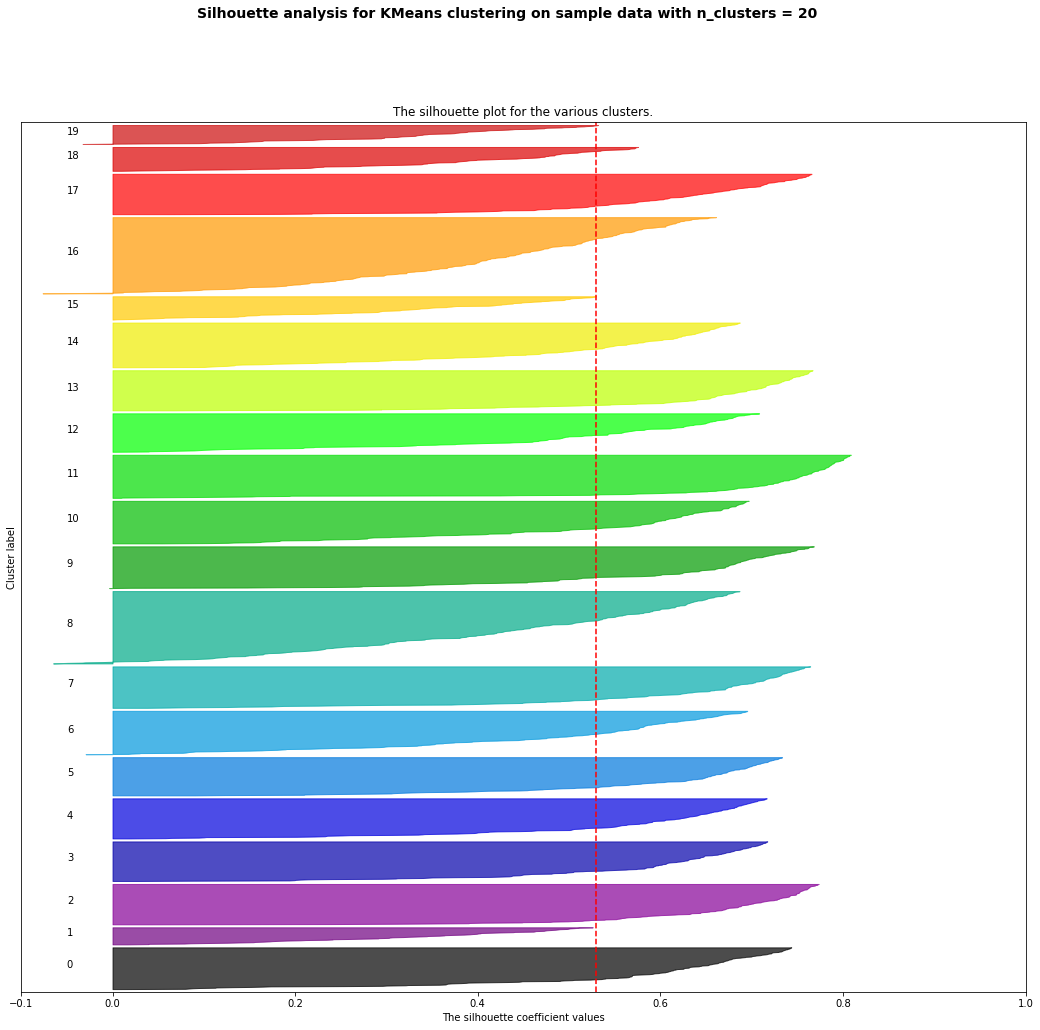

For n_clusters = 20 The value of p =  2.0  The average silhouette_score is : 0.5259427795522206


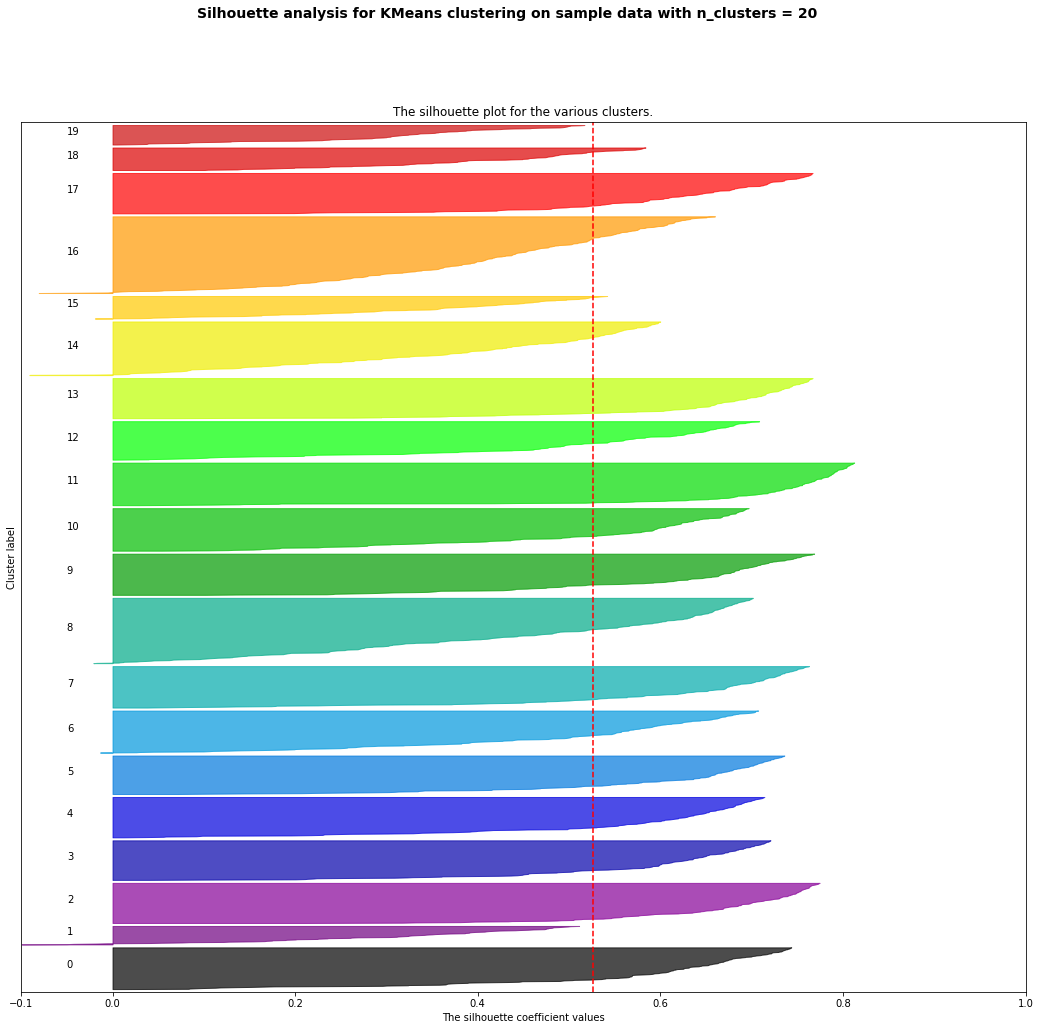

For n_clusters = 20 The value of p =  2.5  The average silhouette_score is : 0.5242446424326868


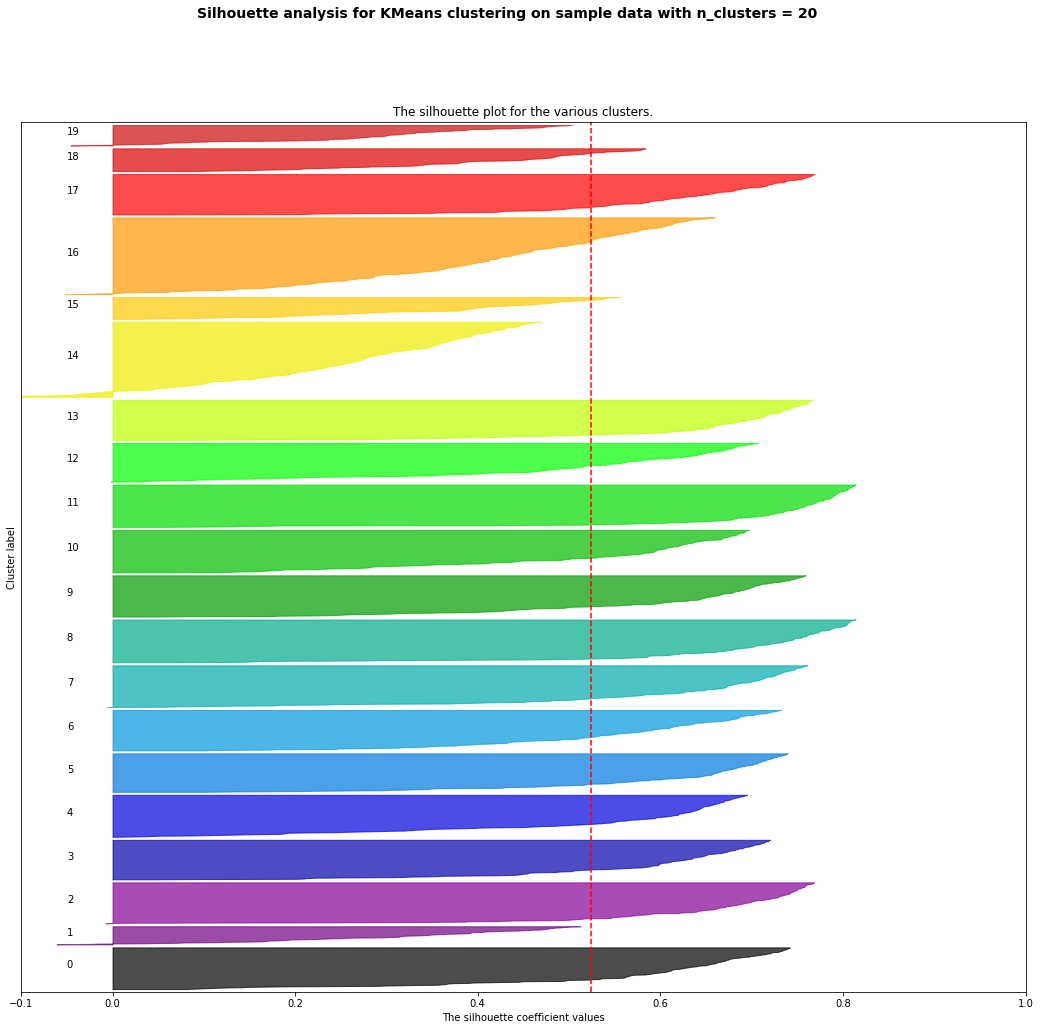

For n_clusters = 20 The value of p =  3.0  The average silhouette_score is : 0.5238019012710734


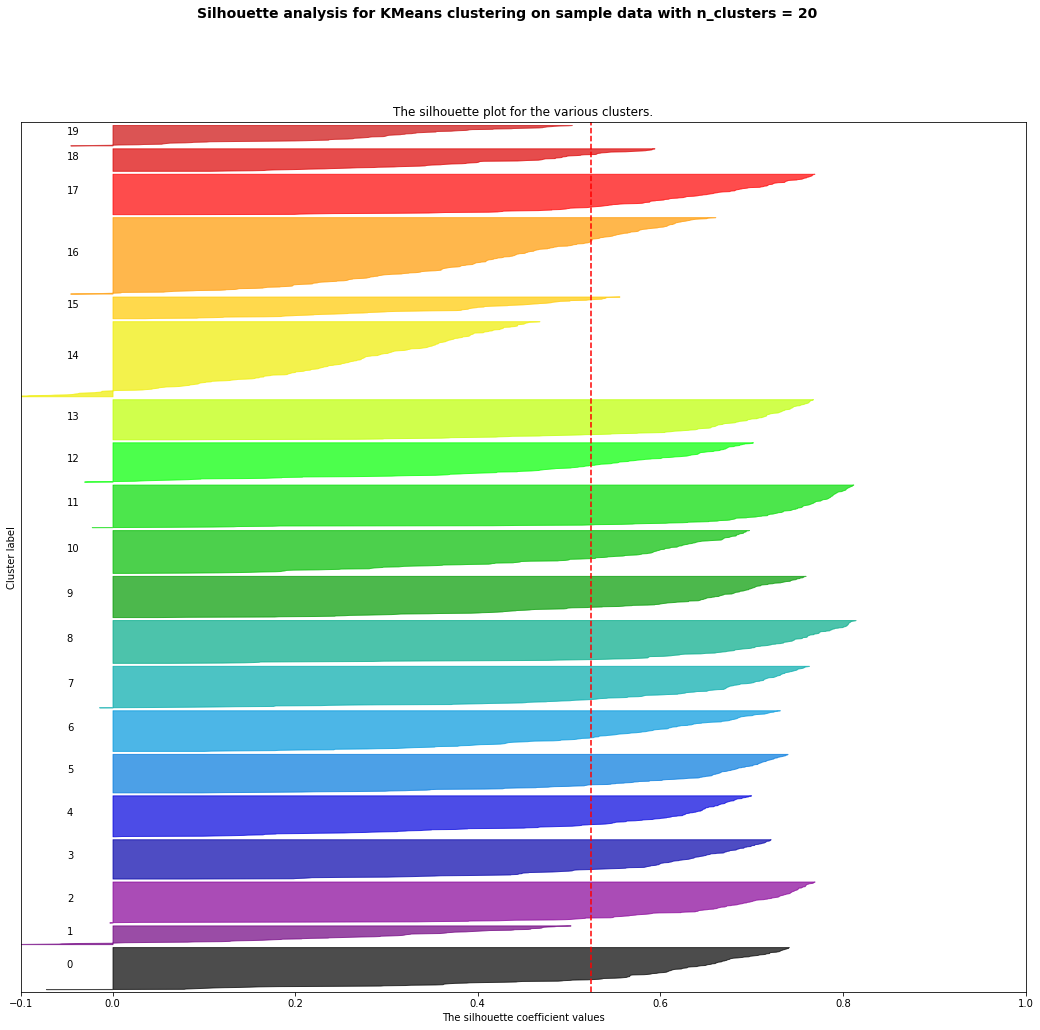

For n_clusters = 20 The value of p =  3.5  The average silhouette_score is : 0.5218628638003711


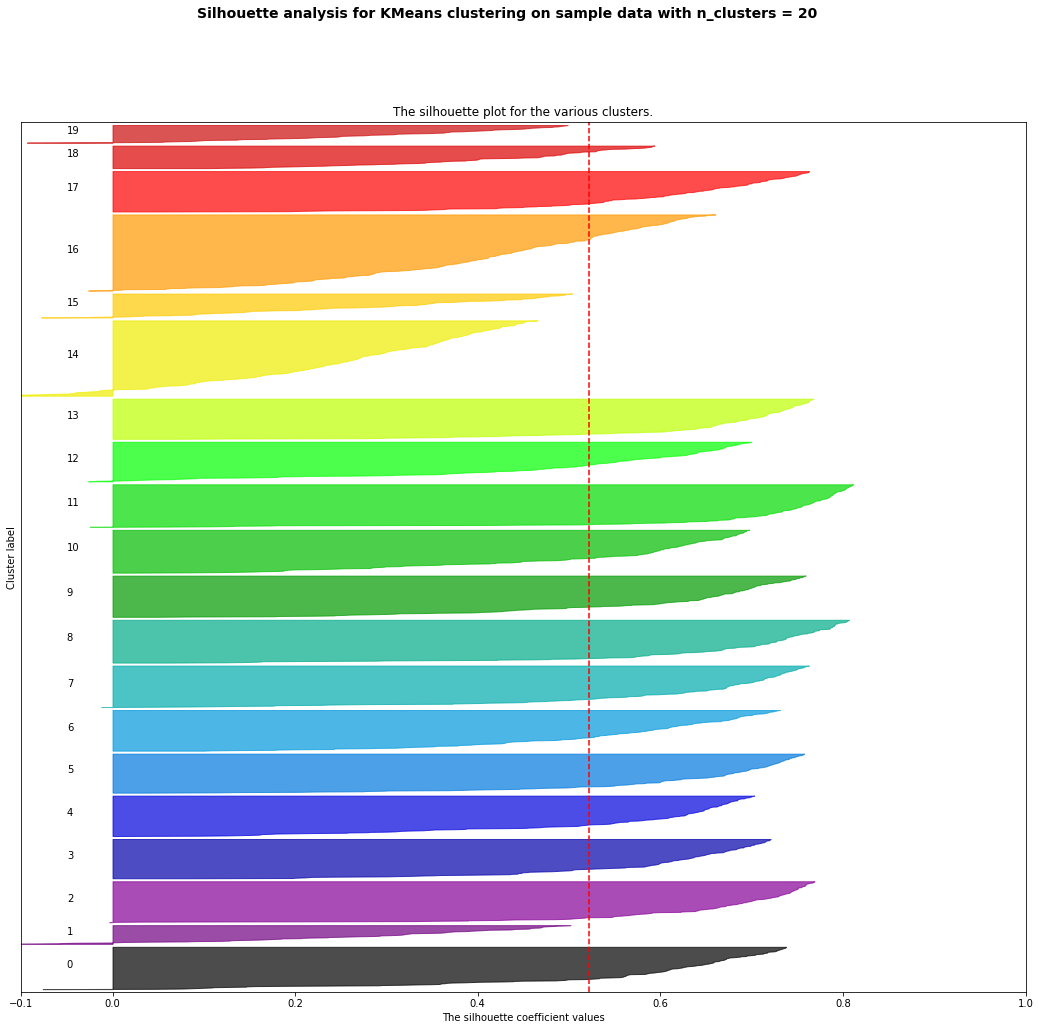

In [32]:
def output_for_csv():
  df=read_dataset_csv()
  X1=df['X'],df['Y']

def output_for_txt(filename):
  
  df=read_txt(filename)
  for p in range(2,8):
    k=Kmeans(K=20,iter=150,p=p/2)
    y_pred=k.predict(np.array(df),choice=1)
    k.centroids=np.array(k.centroids, dtype='int')
    # for i in range(k.K):
    #   print(*k.centroids[i])
    labels,silhouette_avg = SIL_score(df,k.clusters)
    print("For n_clusters =", k.K,"The value of p = ",p/2," The average silhouette_score is :", silhouette_avg)
    sil_visualization(X=np.array(df),cluster_labels=labels,n_clusters=k.K,silhouette_avg=silhouette_avg,centroid=k.centroids)
  return
output_for_txt("A1.txt")


<h1>Observation :</h1> 
For dataset1 we see at value of random_state = 1000 we get the correct expected clustering. This clearly suggests randomisation has to be run multiple times and the best one (need to make a metric for this) has to be picked.